# Exercise 2: Generative prior for imaging inverse problems

<br/><br/>

<a target="_blank" href="https://colab.research.google.com/github/generativemodelingmva/generativemodelingmva.github.io/blob/main/tp2324/tp5_exo2_inverse_problem_with_generative_prior.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br/><br/>

**Authors:**

Bruno Galerne: https://www.idpoisson.fr/galerne/

Arthur Leclaire: https://perso.telecom-paristech.fr/aleclaire/

<br/><br/>
You should complete the code regions marked with `### ... ###`


<br/><br/>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.fft import fft2, ifft2, fftshift, ifftshift
from torch.optim.lr_scheduler import StepLR
import torch.autograd as autograd
import os

from PIL import Image
from IPython.display import display

# viewimage
import tempfile
import IPython
from skimage.transform import rescale

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def stretch(x):
# stretch values such that [min. max]->[0,1]
    m = torch.min(x)
    M = torch.max(x)
    if M>m:
        return((x-m)/(M-m))
    else:
        return(torch.zeros(x.shape))

def imshow(img, unnormalize=False, zoom_factor=3, stretch_opt=False):
    img = img.clone().detach().to('cpu')
    if unnormalize:
        img = img*0.5 + 0.5     # unnormalize
    if stretch_opt:
        img = stretch(img)
    if zoom_factor!=1:
        img = torch.kron(img, torch.ones(1,zoom_factor,zoom_factor))
    pil_img = torchvision.transforms.functional.to_pil_image(1-img)
    display(pil_img)
    return(pil_img)

def viewimage(im, normalize=True,z=2,order=0,titre='',displayfilename = False):
    imin= np.array(im).copy().astype(np.float32)
    imin = rescale(imin, z, order=order)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

!wget https://perso.telecom-paristech.fr/aleclaire/mva/tpdeblur.zip
!unzip tpdeblur.zip

cuda
--2024-02-22 16:56:00--  https://perso.telecom-paristech.fr/aleclaire/mva/tpdeblur.zip
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774047 (756K) [application/zip]
Saving to: ‘tpdeblur.zip’

tpdeblur.zip        100%[===================>] 755.91K  1.30MB/s    in 0.6s    

2024-02-22 16:56:02 (1.30 MB/s) - ‘tpdeblur.zip’ saved [774047/774047]

Archive:  tpdeblur.zip
   creating: im/
  inflating: im/simpson512crop.png   
  inflating: im/simpson512.png       
  inflating: im/room.png             
  inflating: im/tshirt.png           
   creating: kernels/
  inflating: kernels/kernel_0.png    
  inflating: kernels/kernel_1.png    
  inflating: kernels/kernel_10.png   
  inflating: kernels/kernel_11.png   
  inflating: kernels/kernel_2.png    
  inflating: kernels/ke

## Introduction

In this notebook we will use a generative model as an image prior to solve an imaging inverse problem.
This amounts to limit the space of images to the subset
$$
\{x = G(z),~z\in\mathbb{R}^k\} \subset \mathbb{R}^d
$$
to solve a least squares inverse problem
$$
\min_{x} \|Ax - y \|^2.
$$

## Load pretrained generative network:

--2024-02-22 15:39:31--  https://www.idpoisson.fr/galerne/mva/GAN_G_net_ep100.pth
Resolving www.idpoisson.fr (www.idpoisson.fr)... 147.210.130.50
Connecting to www.idpoisson.fr (www.idpoisson.fr)|147.210.130.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2170775 (2.1M)
Saving to: ‘GAN_G_net_ep100.pth’

GAN_G_net_ep100.pth 100%[===================>]   2.07M  1.97MB/s    in 1.1s    

2024-02-22 15:39:34 (1.97 MB/s) - ‘GAN_G_net_ep100.pth’ saved [2170775/2170775]

Generator with random init:


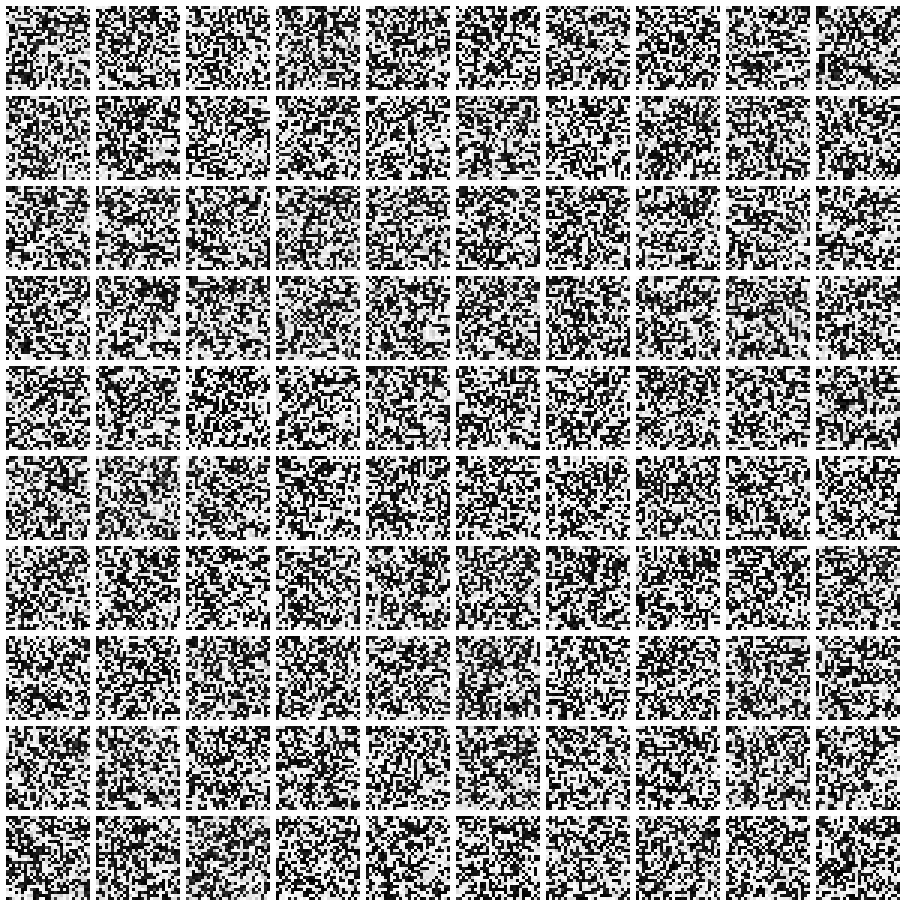

Pretrained generator:


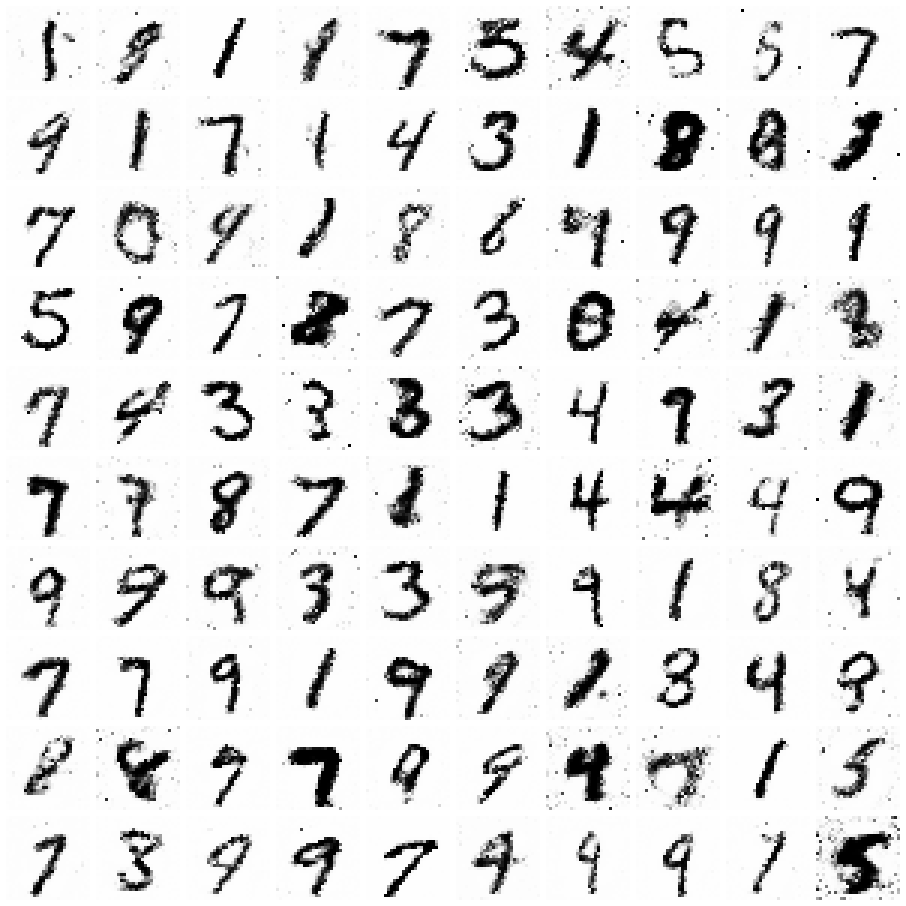

In [ ]:
# load a pre-trained generative network
!wget -c 'https://www.idpoisson.fr/galerne/mva/GAN_G_net_ep100.pth'

# Generator network:
class G_Net(nn.Module):
  def __init__(self, k):
    super(G_Net, self).__init__()
    self.fc1 = nn.Linear(k, 256)
    self.fc2 = nn.Linear(256, 512)
    self.fc3 = nn.Linear(512, 784)

  def forward(self,x):
    x = self.fc1(x)
    x = F.leaky_relu(x, negative_slope=0.2)
    x = self.fc2(x)
    x = F.leaky_relu(x, negative_slope=0.2)
    x = self.fc3(x)
    x = torch.tanh(x)
    x = x.view(-1,1,28,28) # batch_size x channels x H x W
    return(x)

def show(G,z=None):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(100,k).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=10))
    return(pil_img)
    #print(disnet(genimages))

# initialize generator (with random weights)
k = 32
G_net = G_Net(k).to(device)
z = torch.randn(100,k).to(device)

print("Generator with random init:")
show(G_net);
G_net.load_state_dict(torch.load('GAN_G_net_ep100.pth', map_location=device))
G_net.eval()
G_net.requires_grad_(False)
print("Pretrained generator:")
show(G_net,z=z);

## Operator of inverse problem

Implement an operator $A$ that does crude subsampling with stride s.
Implement also a version of $A$ that applies on a batch.

In [ ]:

# the input x is a gray-level image of shape 1xMxN
def A(x,s=2):
  return x[:,::s,::s]

# the input x is a batch of gray-level images of shape bx1xMxN
def batchA(x,s=2):
    return x[:,:,::s,::s]

## Input data

We will consider images from the **MNIST test set** and a generative model trained as a GAN using a the disjoint **MNIST training set**.

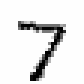

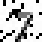

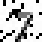

In [ ]:
# input
# transformtest = transforms.ToTensor()
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
datatest = datasets.MNIST('.', train=False, download=True, transform=transform)
input_idx = 0 # a seven
#input_idx = 99 # a nine
#input_idx = 3 # a zero
#input_idx = 5 # a one
#input_idx = 21 # a six
#input_idx = 1 # a two
#input_idx = 4 # a four
#input_idx = 1984 # an unusual 2, hard


x0=  datatest[input_idx][0].to(device)
_, M, N = x0.shape
d = M*N
imshow(x0);

# compute a sample of the direct model y = Ax0 + w
s = 2
w = torch.randn(1,M//s, N//s)*0.01
w = w.to(device)
y = A(x0) + w

imshow(y)

## Pseudo-inverse of operator

Compute the $A^+ y$ by applying gradient descent to the convex function
$$
f(x) = \|Ax - y \|^2
$$

iteration  99 fx =  0.0004664699954446405


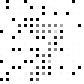

Convergence reached:
iteration  166 fx =  4.973084444248599e-12


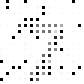

In [ ]:
x = torch.zeros(x0.shape).to(device)
x.requires_grad = True

# compute pseudo-inverse of y
optimizer = optim.SGD([x], lr = 0.01, momentum = 0.9)
niter = 1000
for it in range(niter):
    optimizer.zero_grad()
    fx = torch.norm(A(x) - y)**2/2
    fx.backward() #compute the gradients
    optimizer.step() #Update the weights
    if fx.item()<1e-10:
        print("Convergence reached:")
        print("iteration ", it, "fx = ", fx.item())
        imshow(x);
        break
    if it%(niter//10) == niter//10-1:
        print("iteration ", it, "fx = ", fx.item())
        imshow(x);

## GAN prior for solving the inverse problem

We solve for
$$
\hat x = G(\hat z)
\quad \text{with $\hat z$ solution of}\quad
\min_{z\in\mathbb{R}^{k}} \|A(G(z)) - y \|^2.
$$
Since the result highly depends on the initialization, we will optimize for a batch of $b=10$ $z$ values.

**Exercise:**
Implement a script that:
1. Initialize an array $z = (z^0, \dots, z^{b-1})$ of $b$ random latent code.
2. Optimize $z$ to minimize the sum
$$
\sum_{j=0}^{b-1} \|A(G(z^j)) - y \|^2
$$
using ```optim.Adam([z], lr = 0.01)``` as optimizer for ```niter = 10**4```.
3. Display the $b=10$ corresponding images $G(z^j)$ at initialization and at 10 intermediary steps as well as the iteration number and the value of the function to optimize.

Here, we train a pre-trained generator of MNIST digits. The goal here is to adjuste the weights of the neural network so it fixes the degredations artificially added with subsampling and noise.

Solution:


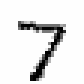

iteration  0 fx =  356.3364562988281
iteration  999 fx =  51.92754364013672
iteration  1999 fx =  44.14579772949219
iteration  2999 fx =  43.63658142089844
iteration  3999 fx =  43.508148193359375
iteration  4999 fx =  43.157814025878906
iteration  5999 fx =  43.02455139160156
iteration  6999 fx =  42.78620910644531
iteration  7999 fx =  42.73037338256836
iteration  8999 fx =  42.83723068237305
iteration  9999 fx =  42.51776885986328


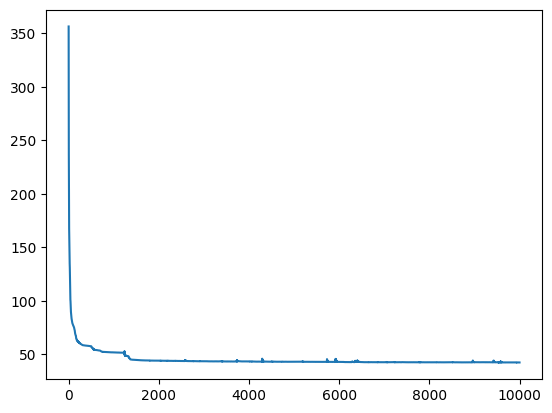

In [ ]:
b = 10 #Number of batchs
torch.set_grad_enabled(True)

# initialize pre-trained generator
k = 32 #It is imposed by the generator, it it the dimension of latent space
G_net.load_state_dict(torch.load('GAN_G_net_ep100.pth', map_location=device))
G_net.eval()
G_net.requires_grad_(False) #I don't know what it is for

print('Solution:')
imshow(x0, False);
niter = 10**4
losslist = []

z = torch.randn(b,k, device = device, requires_grad = True) #parameters out of the loop, which we wish to optimize
optimizer = optim.Adam([z], lr = 0.1) #Il faut définir z avant la boucle !

for it in range(niter):
    optimizer.zero_grad()
    x = G_net(z)
    A = batchA(x)
    fx = 1/2*torch.sum((A - y)**2)
    fx.backward() #Compute the gradients
    optimizer.step()
    losslist.append(fx.item())

    if it==0 or it%(niter//10) == niter//10 - 1:
        print("iteration ", it, "fx = ", fx.item())
        #show(G_net,z=z)

plt.plot(losslist)

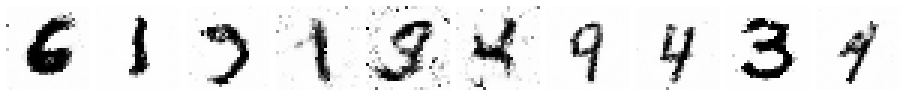

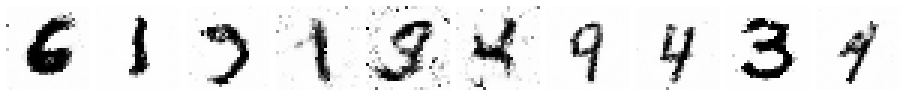

In [ ]:
z = torch.randn(b,k).to(device)
show(G_net,z=z)

# Repeat the experiment with a DCGAN pre-learned with WGAN-GP

Downloading: "https://perso.telecom-paristech.fr/aleclaire/mva/tp/wgan_epoch100.pt" to /root/.cache/torch/hub/checkpoints/wgan_epoch100.pt


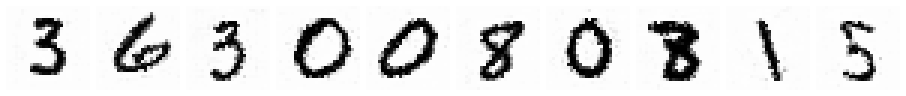

In [ ]:
nz = 100 #latent space dimension
ngf = 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

# download a prelearned DCGAN (see Practical Session 3)
G = Generator().to(device)
G.load_state_dict(torch.hub.load_state_dict_from_url('https://perso.telecom-paristech.fr/aleclaire/mva/tp/wgan_epoch100.pt', progress=False))
G.eval();  # Turn generator in evaluation mode to fix BatchNorm layers

G_net.eval()
G.requires_grad_(False)
zt = torch.randn(b,nz,1,1).to(device)
show(G,zt);

Solution:


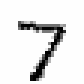

iteration  0 fx =  508.7398986816406
iteration  999 fx =  62.738731384277344
iteration  1999 fx =  54.05299758911133
iteration  2999 fx =  49.6221923828125
iteration  3999 fx =  49.813594818115234
iteration  4999 fx =  48.4119873046875
iteration  5999 fx =  47.43617630004883
iteration  6999 fx =  41.04204559326172
iteration  7999 fx =  41.37482452392578
iteration  8999 fx =  39.58669662475586
iteration  9999 fx =  39.26485824584961


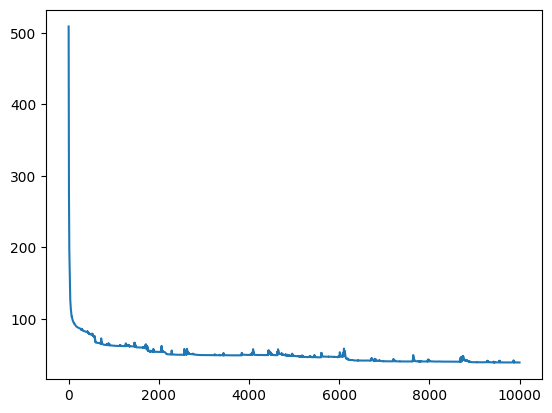

In [ ]:
b = 10 #Number of batchs
torch.set_grad_enabled(True)

# initialize pre-trained generator
k = 32 #It is imposed by the generator, it it the dimension of latent space
G = Generator().to(device)
G.load_state_dict(torch.hub.load_state_dict_from_url('https://perso.telecom-paristech.fr/aleclaire/mva/tp/wgan_epoch100.pt', progress=False))
G.eval()
G.requires_grad_(False)

print('Solution:')
imshow(x0, False);
niter = 10**4
losslist = []

z = torch.randn(b,nz, device = device, requires_grad = True) #parameters out of the loop, which we wish to optimize
optimizer = optim.Adam([z], lr = 0.1) #Il faut définir z avant la boucle !


for it in range(niter):
    optimizer.zero_grad()
    x = G(z.reshape(b,nz,1,1))
    A = batchA(x)
    fx = 1/2*torch.sum((A - y)**2)
    fx.backward() #Compute the gradients
    optimizer.step()
    losslist.append(fx.item())

    if it==0 or it%(niter//10) == niter//10 - 1:
        print("iteration ", it, "fx = ", fx.item())
        #show(G_net,z=z)

plt.plot(losslist)

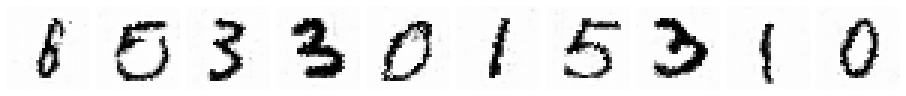

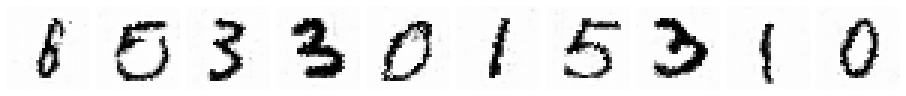

In [ ]:
z = torch.randn(b,nz,1,1).to(device)
show(G,z=z)

## Adjust the exercise for simple denoising ($A= \mathsf{Id}$)

Remark that it is equivalent to a simple GAN inversion.

On a batch of sampled images $x$, compute the average value of $\|G(z_*) - x\|$.

Solution:


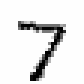

iteration  0 fx =  5935.3056640625
iteration  999 fx =  4043.88330078125
iteration  1999 fx =  4018.7138671875
iteration  2999 fx =  4002.72998046875
iteration  3999 fx =  3994.3779296875
iteration  4999 fx =  3989.4501953125
iteration  5999 fx =  3985.891357421875
iteration  6999 fx =  3983.2412109375
iteration  7999 fx =  3980.867431640625
iteration  8999 fx =  3977.249267578125
iteration  9999 fx =  3975.06982421875


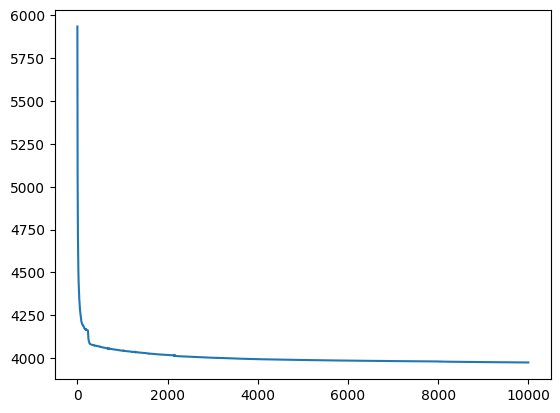

In [ ]:
w = torch.randn(x0.shape).to(device)
y_noise = x0 + w

b = 10 #Number of batches
torch.set_grad_enabled(True)

# initialize pre-trained generator
k = 32 #It is imposed by the generator, it is the dimension of latent space
G_net.load_state_dict(torch.load('GAN_G_net_ep100.pth', map_location=device))
G_net.eval()
G_net.requires_grad_(False)

print('Solution:')
imshow(x0, False);
niter = 10**4
losslist = []

z = torch.randn(b,k, device = device, requires_grad = True) #parameters out of the loop, which we wish to optimize
optimizer = optim.Adam([z], lr = 0.1) #Il faut définir z avant la boucle !

for it in range(niter):
    optimizer.zero_grad()
    x = G_net(z)
    fx = 1/2*torch.sum((x - y_noise)**2)
    fx.backward() #Compute the gradients
    optimizer.step()
    losslist.append(fx.item())

    if it==0 or it%(niter//10) == niter//10 - 1:
        print("iteration ", it, "fx = ", fx.item())
        #show(G_net,z=z)

plt.plot(losslist)

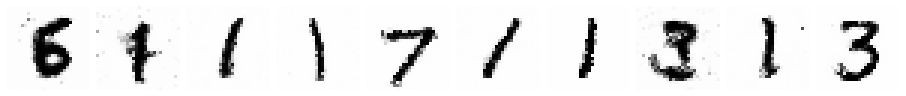

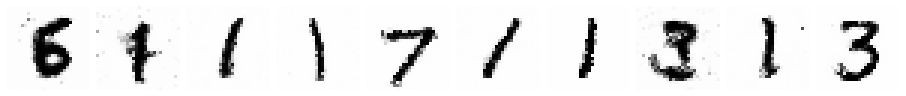

In [ ]:
z = torch.randn(b,k).to(device)
show(G_net,z=z)

## Repeat the exercise a subsampling operator A that includes a anti-aliasing filter

Adapt the previous operator so that it does a pre-filtering before subsampling.

You may use the following Butterworth filter working on normalized frequencies $(-\frac{1}{2},\frac{1}{2})^2$.

You may try subsampling with stride larger than 2, and adjust the pre-filtering accordingly.

In [ ]:
fc = .24  # cutoff frequency
n=20      # order of the filter
f = torch.tensor([0.2])
bf = 1/torch.sqrt(1+(f/fc)**(2*n))

xi = torch.arange(M)
ind = (xi>M/2)
xi[ind] = xi[ind]-M
zeta = torch.arange(N)
ind = (zeta>N/2)
zeta[ind] = zeta[ind]-N
Xi,Zeta = torch.meshgrid(xi,zeta,indexing='ij')

bf1 = 1/torch.sqrt(1+(Xi/(M*fc))**(2*n)).to(device)
bf2 = 1/torch.sqrt(1+(Zeta/(N*fc))**(2*n)).to(device)
bf = bf1*bf2 #recall the filter is already in frequence mode



Solution:


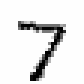

iteration  0 fx =  392.2572021484375
iteration  999 fx =  66.60588836669922
iteration  1999 fx =  62.87522506713867
iteration  2999 fx =  61.602073669433594
iteration  3999 fx =  60.59922409057617
iteration  4999 fx =  59.690242767333984
iteration  5999 fx =  59.27899932861328
iteration  6999 fx =  58.918174743652344
iteration  7999 fx =  58.62126541137695
iteration  8999 fx =  58.40020751953125
iteration  9999 fx =  59.366580963134766


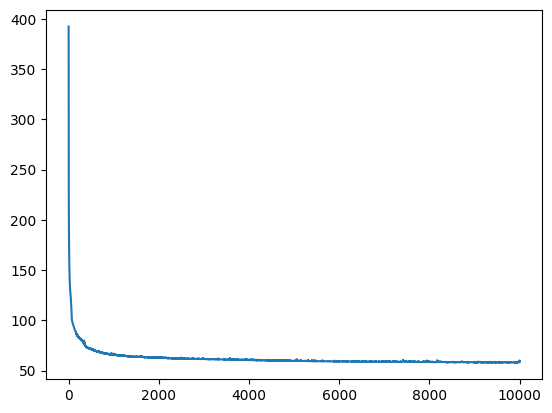

In [ ]:
def filter_subsampling(x, s = 2):
  X = ifft2(bf*fft2(x)).real #filter
  return X[:,:,::s,::s] #subsampling

b = 10 #Number of batchs
torch.set_grad_enabled(True)

w = torch.randn(1,1,28,28)*0.1
y_sub = filter_subsampling(x0.reshape(1,1,28,28)) + w

# initialize pre-trained generator
k = 32 #It is imposed by the generator, it it the dimension of latent space
G = Generator().to(device)
G.load_state_dict(torch.hub.load_state_dict_from_url('https://perso.telecom-paristech.fr/aleclaire/mva/tp/wgan_epoch100.pt', progress=False))
G.eval()
G.requires_grad_(False)

print('Solution:')
imshow(x0, False);
niter = 10**4
losslist = []

z = torch.randn(b,nz, device = device, requires_grad = True) #parameters out of the loop, which we wish to optimize
optimizer = optim.Adam([z], lr = 0.1) #Il faut définir z avant la boucle !

for it in range(niter):
    optimizer.zero_grad()
    x = G(z.reshape(b,nz,1,1))
    A = filter_subsampling(x)
    fx = 1/2*torch.sum((A - y_sub)**2)
    fx.backward() #Compute the gradients
    optimizer.step()
    losslist.append(fx.item())

    if it==0 or it%(niter//10) == niter//10 - 1:
        print("iteration ", it, "fx = ", fx.item())
        #show(G_net,z=z)

plt.plot(losslist)

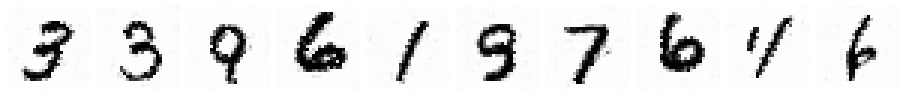

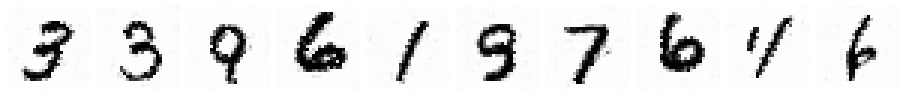

In [ ]:
z = torch.randn(b,nz,1,1).to(device)
show(G,z=z)

## Repeat the exercise with a blurring operator

You may use the blur operator of Exercise 1.

Compare the results obtained with the generative prior and with the $\mathsf{TV}_{\varepsilon}$ regularization.

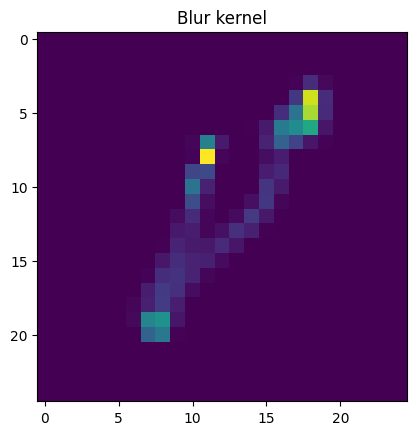

In [ ]:
# Load a blur kernel
kt = torch.tensor(np.loadtxt('kernels/kernel8.txt'))
# kt = np.loadtxt('kernels/levin7.txt')
(m,n) = kt.shape

plt.imshow(kt)
plt.title('Blur kernel')
plt.show()

# Embed the kernel in a MxN image, and put center at pixel (0,0)
k = torch.zeros((M,N))
k[0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1))
fk = fft2(k).to(device)

Solution:


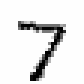

iteration  0 fx =  279.2138977050781
iteration  999 fx =  46.057769775390625
iteration  1999 fx =  45.31011962890625
iteration  2999 fx =  44.94757843017578
iteration  3999 fx =  44.751953125
iteration  4999 fx =  44.651878356933594
iteration  5999 fx =  44.595855712890625
iteration  6999 fx =  44.53031539916992
iteration  7999 fx =  44.47642135620117
iteration  8999 fx =  44.427005767822266
iteration  9999 fx =  44.377593994140625


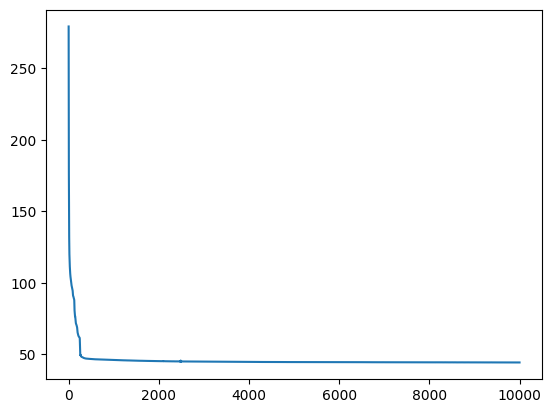

In [ ]:
def blur(x):
  return ifft2(fk*fft2(x)).real

w = (torch.randn(x0.shape)*0.1).to(device)
y_blur = ifft2(fk*fft2(x0)).real + w


b = 10 #Number of batches
torch.set_grad_enabled(True)

# initialize pre-trained generator
k = 32 #It is imposed by the generator, it is the dimension of latent space
G_net.load_state_dict(torch.load('GAN_G_net_ep100.pth', map_location=device))
G_net.eval()
G_net.requires_grad_(False)

print('Solution:')
imshow(x0, False);
niter = 10**4
losslist = []

z = torch.randn(b,k, device = device, requires_grad = True) #parameters out of the loop, which we wish to optimize
optimizer = optim.Adam([z], lr = 0.1) #Il faut définir z avant la boucle !

for it in range(niter):
    optimizer.zero_grad()
    x = G_net(z)
    A = blur(x)
    fx = 1/2*torch.sum((A - y_blur)**2)
    fx.backward() #Compute the gradients
    optimizer.step()
    losslist.append(fx.item())

    if it==0 or it%(niter//10) == niter//10 - 1:
        print("iteration ", it, "fx = ", fx.item())
        #show(G_net,z=z)

plt.plot(losslist)

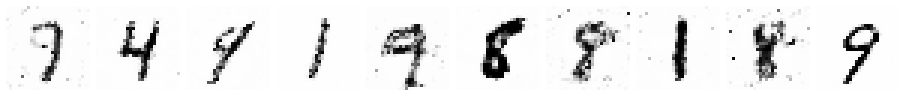

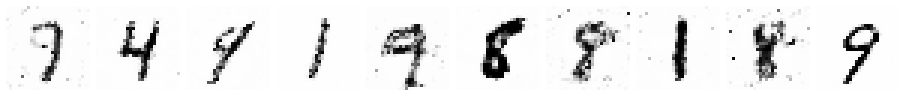

In [ ]:
z = torch.randn(b,k).to(device)
show(G_net,z=z)

## Repeat the exercise with the operator A defined in the next cell

We will now define a new operator $A$ that sums the values of the gray-level image along each vertical, horizontal and diagonal directions.

In [ ]:
# We suppose that:
#  - the input x is a square gray-level image of size 1xMxN with M=N
#  - the output y is 1D tensor of size number of measurements m
#    What is measurements ?

def sum_all_diagonal_matrix(mat: torch.tensor):
    # from: https://stackoverflow.com/questions/57347896/sum-all-diagonals-in-feature-maps-in-parallel-in-pytorch
    n,_ = mat.shape
    zero_mat = torch.zeros((n, n),device=mat.device) # Zero matrix used for padding
    mat_padded =  torch.cat((zero_mat, mat, zero_mat), 1) # pads the matrix on left and right
    mat_strided = mat_padded.as_strided((n, 2*n), (3*n + 1, 1)) # Change the strides
    sum_diags = torch.sum(mat_strided, 0) # Sums the resulting matrix's columns
    return(sum_diags[1:])

def axial_and_diagonal_sum(x):
    # sum over diagoanal:
    _,M,N = x.shape
    xmat = x.reshape(M,N)
    yhori = torch.sum(x, axis=2).flatten()
    yvert = torch.sum(x, axis=1).flatten()
    ydiag = sum_all_diagonal_matrix(xmat).flatten()
    y_anti_diag = sum_all_diagonal_matrix(xmat.flip(1)).flatten()
    y = torch.cat((yhori, yvert, ydiag, y_anti_diag.flip(0)))
    return(y)

# test of axial_and_diagonal_sum(x)
t = torch.diag(1+torch.arange(4)).unsqueeze(0)
print("Test of axial_and_diagonal_sum(x):")
print("Input:", t)
print("Output:", axial_and_diagonal_sum(t))

opA = axial_and_diagonal_sum(x0)
w = (torch.randn(opA.shape)).to(device)
y = opA + w

def batchopA(x):
  # apply opA to each image of a batch and return a tensor:
  listAx = []
  for bidx in range(x.shape[0]):
    listAx.append(opA(x[bidx,:,:]))
  Ax = torch.stack(listAx)
  return(Ax)


### ... Try y = Ax ... ##



# print('Plot of y: (yhori, yvert, ydiag, y_anti_diag)')
# plt.figure(figsize=(20,4))
# plt.bar(range(y.numel()), y.to('cpu').numpy());


Test of axial_and_diagonal_sum(x):
Input: tensor([[[1, 0, 0, 0],
         [0, 2, 0, 0],
         [0, 0, 3, 0],
         [0, 0, 0, 4]]])
Output: tensor([ 1.,  2.,  3.,  4.,  1.,  2.,  3.,  4.,  0.,  0.,  0., 10.,  0.,  0.,
         0.,  1.,  0.,  2.,  0.,  3.,  0.,  4.])
